<a href="https://colab.research.google.com/github/Alamsyah-WM/Predict-DNA-binding-protein-with-ML-and-DL/blob/main/BioInformatik_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Library

In [88]:
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plotting
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.preprocessing import StandardScaler  # For scaling features
from collections import Counter # For counting features
from sklearn.svm import SVC # For Classification model SVM
from sklearn.neural_network import MLPClassifier # For MLP Classifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # For evaulate model performance

##Load Dataset

In [89]:
pdb = pd.read_csv('/content/PDB1063-186.csv')
uniswiss = pd.read_csv('/content/UniSwiss.csv')

print("Raw PDB Dataset:")
print(pdb.head())

print("\nRaw UniSwiss Dataset:")
print(uniswiss.head())

print("\nPDB Info:")
print(pdb.info())
print("Shape:", pdb.shape)

print("\nUniSwiss Info:")
print(uniswiss.info())
print("Shape:", uniswiss.shape)


Raw PDB Dataset:
  identifier                                           sequence  label    set
0      1AKHB  TKPYRGHRFTKENVRILESWFAKNIENPYLDTKGLENLMKNTSLSR...      1  train
1      1B6WA  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...      1  train
2      1C1KA  MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVS...      1  train
3      1C6VX  QQSKNSKFKNFRVYYREGRDQLWKGPGELLWKGEGAVLLKVGTDIK...      1  train
4      1C6VD  IHGQVNSDLGTWQMDCTHLEGKIVIVAVHVASGFIEAEVIPQETGR...      1  train

Raw UniSwiss Dataset:
   identifier                                           sequence  label    set
0      P08956  MMNKSNFEFLKGVNDFTYAIACAAENNYPDDPNTTLIKMRMFGEAT...      1  train
1      P27235  MPPQRSRRRKRASATQLYQTCKASGTCPPDVIPKVEGTTLADKILQ...      1  train
2      P0AD01  MINVLIIDDDAMVAELNRRYVAQIPGFQCCGTASTLEKAKEIIFNS...      1  train
3  A0A024B7I0  MAYMCADSGNLMAIAQQVIKQKQQQEQQQQQSHHPQQQFLGLNPFS...      1  train
4      F4I443  MAEFTNMLMNPWVLHLQKLELELKCPLCLKLLNRPVLLPCDHVFCD...      1  train

PDB Info:
<class 

##Understanding Dataset

In [90]:
# Count sequence length for each protein seqeuence
pdb['seq_len'] = pdb['sequence'].str.len()
uniswiss['seq_len'] = uniswiss['sequence'].str.len()

# Count the label distribution balances
pdb_label_counts = pdb['label'].value_counts()
uniswiss_label_counts = uniswiss['label'].value_counts()

# Count total set distribution for split
pdb_set_counts = pdb['set'].value_counts()
pdb_set_percentage = (pdb_set_counts / len(pdb)) * 100 #Calculate into percentage
uniswiss_set_counts = uniswiss['set'].value_counts()
uniswiss_set_percentage = (uniswiss_set_counts / len(uniswiss)) * 100 #Calculate into percentage

# Get information about the datasets
print("Total PDB Sequence:", len(pdb))
print("Total Uniswiss Sequence:", len(uniswiss))

print("\nAverage PDB Sequence Length:", int(pdb['seq_len'].mean()))
print("Average Uniswiss Sequence Length:", int(uniswiss['seq_len'].mean()))

print("\nMedian PDB Sequence Length:", round(pdb['seq_len'].median(), 2))
print("Median UniSwiss Sequence Length:", round(uniswiss['seq_len'].median(), 2))

print("\nStd Dev PDB Sequence Length:", round(pdb['seq_len'].std(), 2))
print("Std Dev UniSwiss Sequence Length:", round(uniswiss['seq_len'].std(), 2))

print("\nMinimum PDB Sequence Length:", pdb['seq_len'].min())
print("Maximum PDB Sequence Length:", pdb['seq_len'].max())

print("\nMinimum Uniswiss Sequence Length:", uniswiss['seq_len'].min())
print("Maximum Uniswiss Sequence Length:", uniswiss['seq_len'].max())

print("\nUnique identifiers PDB:", pdb['identifier'].nunique())
print("Unique identifiers UniSwiss:", uniswiss['identifier'].nunique())

print("\nMissing Values in PDB Dataset:")
print(pdb.isnull().sum())
print("\nMissing Values in UniSwiss Dataset:")
print(uniswiss.isnull().sum())

print("\nLabel Distribution in PDB Dataset:")
print(pdb_label_counts)
print("\nLabel Distribution in UniSwiss Dataset:")
print(uniswiss_label_counts)

print("\nRaw PDB Dataset split:")
print(pdb_set_counts)
print(pdb_set_percentage)

print("\nRaw UniSwiss Dataset Split:")
print(uniswiss_set_counts)
print(uniswiss_set_percentage)

Total PDB Sequence: 1249
Total Uniswiss Sequence: 9762

Average PDB Sequence Length: 243
Average Uniswiss Sequence Length: 475

Median PDB Sequence Length: 192.0
Median UniSwiss Sequence Length: 356.0

Std Dev PDB Sequence Length: 184.23
Std Dev UniSwiss Sequence Length: 462.31

Minimum PDB Sequence Length: 50
Maximum PDB Sequence Length: 1323

Minimum Uniswiss Sequence Length: 50
Maximum Uniswiss Sequence Length: 8515

Unique identifiers PDB: 1207
Unique identifiers UniSwiss: 9762

Missing Values in PDB Dataset:
identifier    0
sequence      0
label         0
set           0
seq_len       0
dtype: int64

Missing Values in UniSwiss Dataset:
identifier    0
sequence      0
label         0
set           0
seq_len       0
dtype: int64

Label Distribution in PDB Dataset:
label
0    638
1    611
Name: count, dtype: int64

Label Distribution in UniSwiss Dataset:
label
1    4881
0    4881
Name: count, dtype: int64

Raw PDB Dataset split:
set
train    1063
test      186
Name: count, dtype: int

#**Pre-Processing**
##Objective
1. Cleaning dataset
2. feature extraction
3. Split dataset
4. Scaling


###1. Cleaning dataset

In [92]:
# Clean duplicates dataset
# 1. Drop duplicate identifiers
pdb = pdb.drop_duplicates(subset="identifier", keep="first")
uniswiss = uniswiss.drop_duplicates(subset="identifier", keep="first")

# 2. Convert to uppercase and remove invalid amino acids
valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
pdb['sequence'] = pdb['sequence'].str.upper().apply(
    lambda s: ''.join([a for a in s if a in valid_aa])
)

uniswiss['sequence'] = uniswiss['sequence'].str.upper().apply(
    lambda s: ''.join([a for a in s if a in valid_aa])
)

# Check no null value
pdb = pdb.dropna(subset=['sequence', 'label'])
uniswiss = uniswiss.dropna(subset=['sequence', 'label'])

# Get protein sequence after cleaning
print("PDB protein sequence after cleaning:", len(pdb))
print("UniSwiss protein sequence after cleaning:", len(uniswiss))


PDB protein sequence after cleaning: 1207
UniSwiss protein sequence after cleaning: 9762


###2. Feature Extraction

In [104]:
# feature extraction with AAC Composition-based
def amino_acid_composition(seq):
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    counts = np.array([seq.count(a) for a in aa], dtype=float)
    return counts / len(seq)

# Feature extraction for PDB dataset
X_pdb = np.vstack(pdb['sequence'].apply(amino_acid_composition))
y_pdb = pdb['label'].values

# Feature extraction for UniSwiss dataset
X_uniswiss = np.vstack(uniswiss['sequence'].apply(amino_acid_composition))
y_uniswiss = uniswiss['label'].values

print("PDB feature matrix:", X_pdb.shape)
print("UniSwiss feature matrix:", X_uniswiss.shape)

print("\nTop 5 first row PDB from AAC:")
print(pd.DataFrame(X_pdb[:5], columns=list('ACDEFGHIKLMNPQRSTVWY')).round(3))

print("\nTop 5 first row UniSwiss from AAC:")
print(pd.DataFrame(X_uniswiss[:5], columns=list('ACDEFGHIKLMNPQRSTVWY')).round(3))

PDB feature matrix: (1207, 20)
UniSwiss feature matrix: (9762, 20)

Top 5 first row PDB from AAC:
       A      C      D      E      F      G      H      I      K      L  \
0  0.048  0.000  0.024  0.096  0.024  0.036  0.012  0.072  0.133  0.108   
1  0.159  0.000  0.072  0.101  0.014  0.058  0.014  0.145  0.101  0.072   
2  0.051  0.009  0.065  0.055  0.065  0.028  0.009  0.106  0.129  0.083   
3  0.049  0.000  0.062  0.086  0.025  0.123  0.012  0.037  0.136  0.062   
4  0.079  0.012  0.030  0.073  0.030  0.079  0.061  0.085  0.030  0.061   

       M      N      P      Q      R      S      T      V      W      Y  
0  0.012  0.084  0.048  0.012  0.084  0.060  0.072  0.024  0.024  0.024  
1  0.029  0.000  0.029  0.000  0.116  0.029  0.029  0.029  0.000  0.000  
2  0.023  0.060  0.009  0.041  0.041  0.069  0.014  0.051  0.014  0.078  
3  0.012  0.025  0.025  0.037  0.074  0.062  0.025  0.086  0.025  0.037  
4  0.043  0.055  0.030  0.073  0.043  0.030  0.067  0.085  0.024  0.006  

Top 5 

###3. Split Dataset

###4. Scaling

#**Exploraty Data Analysis**
##Objective
1. Analyse sequence length distribution
2. Class Distribution Visualization
3. Amino Acid Composition Visualization


###1. Sequence lenght Distribution

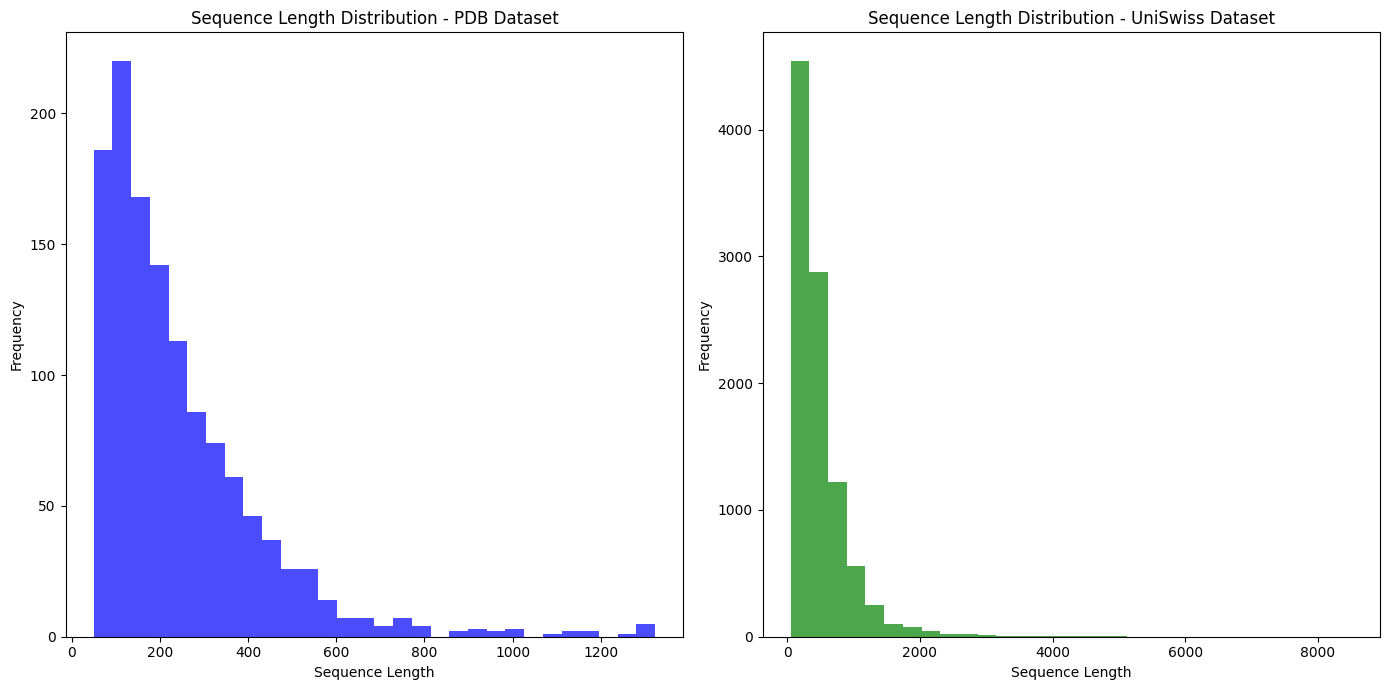

In [29]:
# Plot sequence length distribution for both datasets
plt.figure(figsize=(14, 7))

# PDB Sequence Length Distribution Visual
plt.subplot(1, 2, 1)
plt.hist(pdb['seq_len'], bins=30, alpha=0.7, color='blue')
plt.title('Sequence Length Distribution - PDB Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

# UniSwiss Sequence Length Distribution Visual
plt.subplot(1, 2, 2)
plt.hist(uniswiss['seq_len'], bins=30, alpha=0.7, color='green')
plt.title('Sequence Length Distribution - UniSwiss Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

###2. Class Distribution

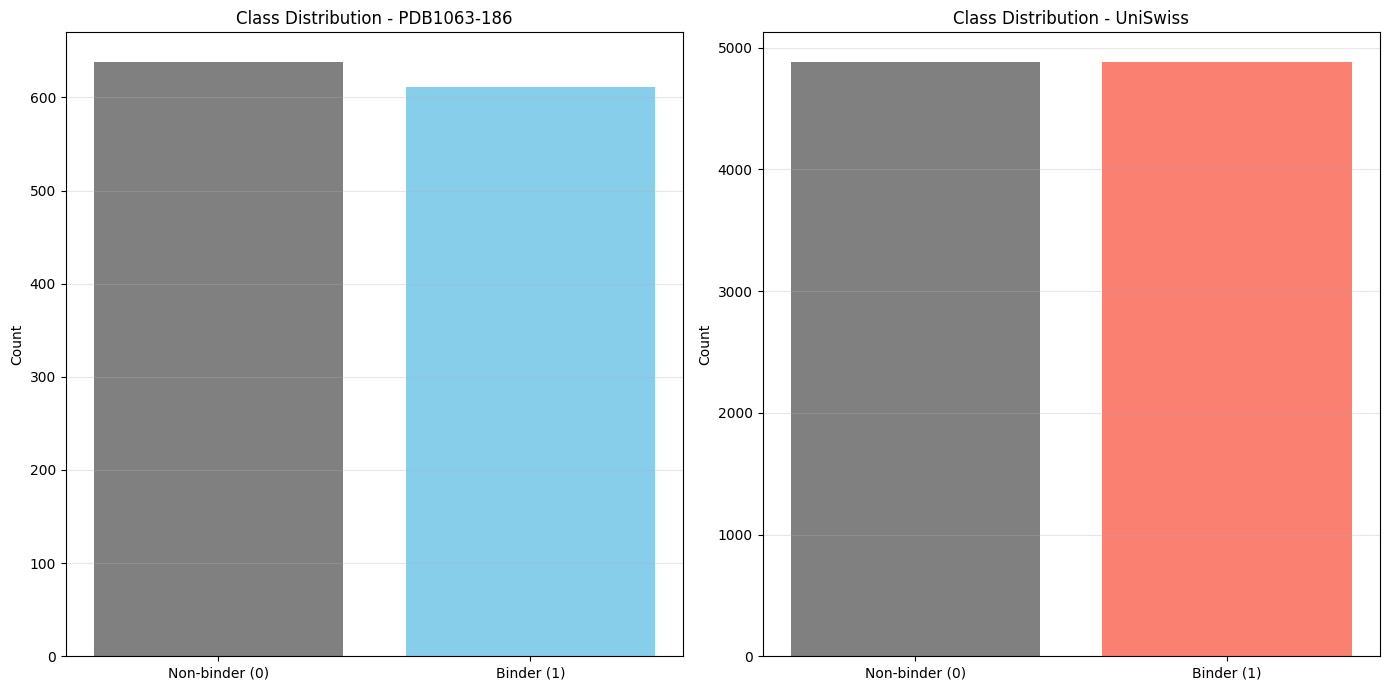

In [39]:
# Plot class for both datasets
plt.figure(figsize=(14, 7))

# Get PDB Class Distribution Visual
plt.subplot(1, 2, 1)
plt.bar(['Non-binder (0)', 'Binder (1)'], pdb_label_counts.sort_index(), color=['gray','skyblue'])
plt.title('Class Distribution - PDB1063-186')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# UniSwiss Class Distribution Visual
plt.subplot(1, 2, 2)
plt.bar(['Non-binder (0)', 'Binder (1)'], uniswiss_label_counts.sort_index(), color=['gray','salmon'])
plt.title('Class Distribution - UniSwiss')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

###3. Amino Acid Composition

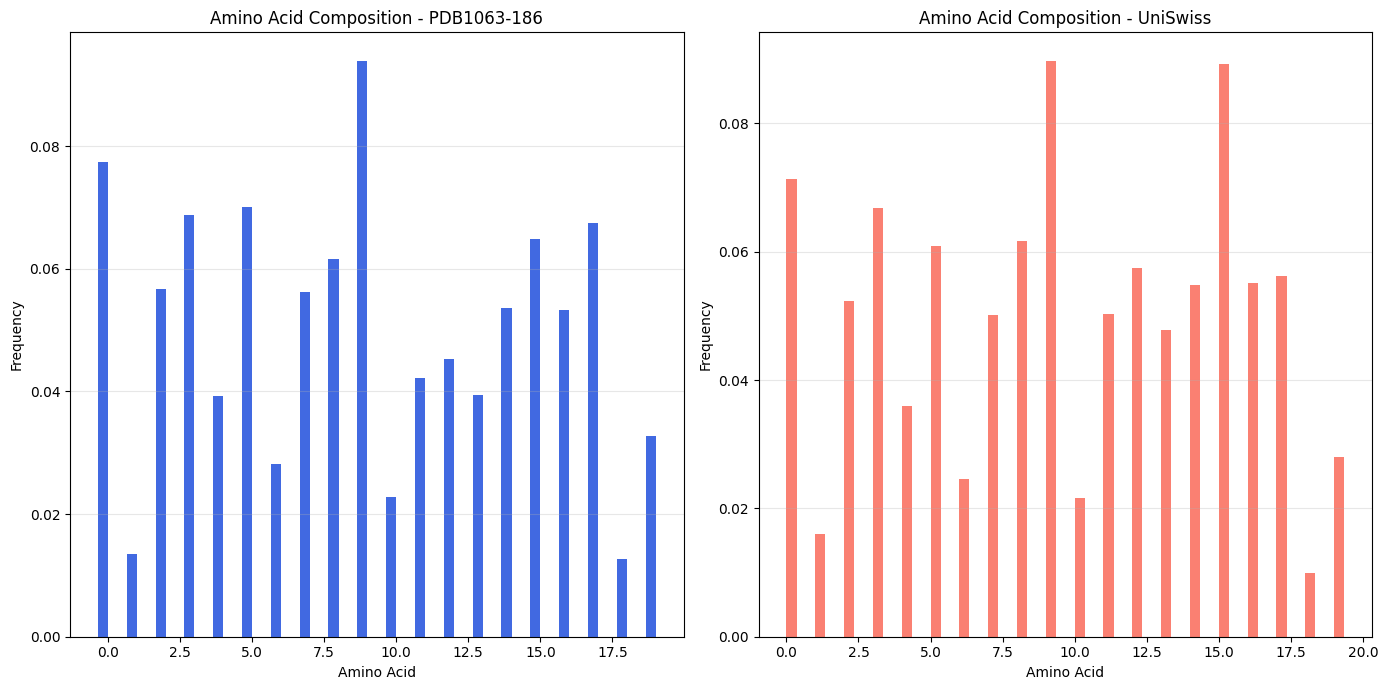

In [56]:
# def amino_acid_composition(sequences):
#     all_seq = ''.join(sequences)
#     freq = Counter(all_seq)
#     amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
#     total = sum(freq.values())
#     composition = [freq.get(aa,0)/total for aa in amino_acids]
#     return amino_acids, composition

# # Calculate composition for Both dataset
# aas, comp_pdb = amino_acid_composition(pdb['sequence'])
# __, comp_uni = amino_acid_composition(uniswiss['sequence'])

# # Plot class for both datasets
# plt.figure(figsize=(14,7))
# width = 0.35
# x = np.arange(len(aas))

# # Get Visual
# plt.subplot(1, 2, 1)
# plt.bar(x - width/2, comp_pdb, width=width, color='royalblue', label='PDB1063-186')
# plt.title('Amino Acid Composition - PDB1063-186')
# plt.xlabel('Amino Acid')
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.3)

# plt.subplot(1, 2, 2)
# plt.bar(x + width/2, comp_uni, width=width, color='salmon', label='UniSwiss')
# plt.title('Amino Acid Composition - UniSwiss')
# plt.xlabel('Amino Acid')
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.3)

# plt.tight_layout()
# plt.show()



#**Pre-Processing & Baseline Models**
##Objective
1. Feature Extraction
2. SVM
3. MLP
4. LightGBM


###1. Feature Extraction

In [63]:
# feature extraction with AAC Composition-based
def AAC(seq):
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    counts = np.array([seq.count(a) for a in aa], dtype=float)
    return counts / len(seq)

X = np.vstack(pdb['sequence'].apply(AAC))
y = pdb['label'].values

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (1249, 20)
Labels shape: (1249,)


###2. SVM

###3. MLP

###4. LightBGM